<img src="header.png" align="left"/>

# Exercise: Classification of MNIST (10 points)


Die goal of this exercise is to create a simple image classification network and to work on the improvement of a model and how to debug and check the training data. We start with a simple CNN model for digit classification of the MNIST dataset [1].  This dataset contains 60,000 scans of digits for training and 10,000 scans of digits for validation. A sample consists of 28x28 features with values between 0 and 255, note that the features are inverted. Actually digits are rather dark on a light background. MNIST digits are light on a dark background.
This example is partly based on a tutorial by Jason Brownlee [2]. 
Please follow the instructions in the notebook.


```
[1] http://yann.lecun.com/exdb/mnist/
[2] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
```

**NOTE**

Document your results by simply adding a markdown cell or a python cell (as comment) and writing your statements into this cell. For some tasks the result cell is already available.




In [2]:
#
# Import some modules
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#
# Turn off errors and warnings (does not work sometimes)
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

#
# Diagram size
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# nasty hack for macos
#
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#
# check version
#
print('starting notebook with tensorflow version {}'.format(tf.version.VERSION))

starting notebook with tensorflow version 2.3.1


# Load and prepare data

In [3]:
#
# Loading of the data (very simplified) with split into train and test data (fixed split)
#
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
#
# Check some data
#
x_train[0][10]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
        90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

In [5]:
#
# Print shapes of data
#
print('training data: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))

training data: X=(60000, 28, 28), y=(60000,)
test     data: X=(10000, 28, 28), y=(10000,)


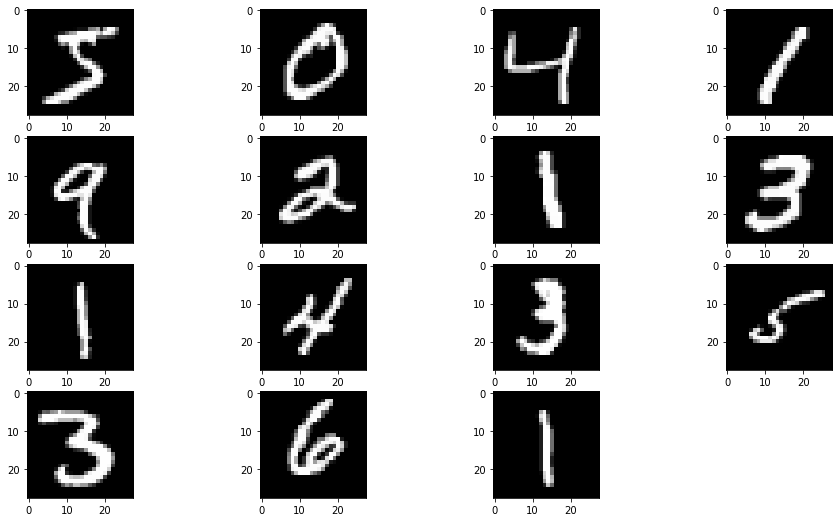

In [6]:
#
# Display some examples of the data
#
for i in range(15):
    plt.subplot(4,4,1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [7]:
#
# Display labels of some data
#
for i in range(15):
    print('label {}'.format(y_train[i]))

label 5
label 0
label 4
label 1
label 9
label 2
label 1
label 3
label 1
label 4
label 3
label 5
label 3
label 6
label 1


# Task: Plot a histogram of the classes of the training data (1 point)

After plotting, give a short estimation if this distribution is OK for use in a classification situation.

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

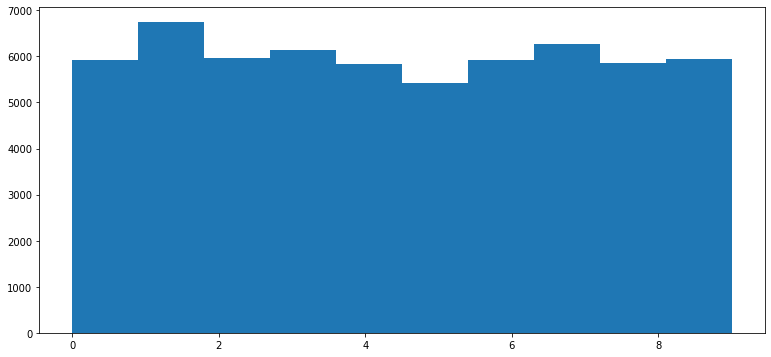

In [8]:
#
# Histogram of class counts (digits)
#
# Task: plot the histogram as array or as plot
#
plt.rcParams['figure.figsize'] = [13, 6]
plt.hist(y_train)

# Although theere is a slight variance in the data distribution, it will probably OK for classifcation.

# Prepare data for classification (1 point)

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
# 
# Change shape of data for model
#
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
#
# Task: find out why the unusual shap of the input data is required? Why is (-1,28,28) not sufficien? (1 point)
# give a short description here in the comment.
# Hint: check the tensorflow keras documentation about 2D cnn layer.
#
# Answer: Images are 4D tensors of shape (samples, height, width, channels) or (samples, channels, height width). The former is the default configuration, the later can be configured with image_data_format. By specifing the channels parameter as 1, we are basically saying that the images are monochromatic (black/white). 

In [11]:
x_train.shape

(60000, 28, 28, 1)

In [12]:
# 
# Scale pixel values into range of 0 to 1
#
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [13]:
# check one transformed sample
x_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [14]:
# 
# One-hot encoding for classes
#
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [15]:
# check the one-hot encoding
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Build the first model (2 points)

In [16]:
#
# Simple CNN model
#
# Task: complete the code for a simple CNN network with one CNN layer.
# Hint: look for examples in the internet or in the slides.
#
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

In [17]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# get a short summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [19]:
# train model
history = model.fit(x_train, y_train, batch_size=128, epochs=5 )

Epoch 1/5
469/469 [==============================] - 7s 15ms/step - loss: 0.1742 - accuracy: 0.9474
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0562 - accuracy: 0.9832
Epoch 3/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0347 - accuracy: 0.9895
Epoch 4/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0236 - accuracy: 0.9926
Epoch 5/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0175 - accuracy: 0.9947


# First prediction with model (1 point)

In [20]:
# predict on data (one sample)
#
# Task: describe the meaning of the numbers returned from the prediction. (1 point)
# write your findings here in the comments
# Hint: look at the definition of the output layer (last layer) in the model.
#
model.predict(x_train[:1])

array([[2.1936233e-12, 9.6083653e-12, 1.0346293e-10, 5.1243136e-05,
        5.9050600e-13, 9.9994874e-01, 8.5885271e-11, 5.8887346e-11,
        9.6451211e-09, 2.4781981e-08]], dtype=float32)

In [21]:
# The softmax function returns a normalised probability distribution where each element is proportional to the exponentials of the input numbers. Which fundamentally means that the sum of all elements has to be 1. The reasonn why it isn't in the example below is because of conversion (?).

In [22]:
prediction = model.predict(x_train[:1])[0]
sum(prediction)

1.0000000178293362

In [23]:
# compare with expexted result
y_train[:1]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [24]:
#
# Measure the accuracy
#
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98520


In [25]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 148 false classifications to expect.


# Print out training progress

In [26]:
#
# Plot loss and accuracy
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

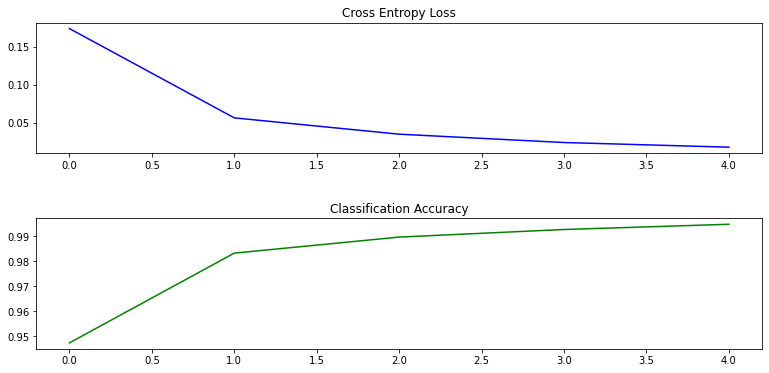

In [27]:
summarize_diagnostics(history,'03_model1')

# Task: Improve the model significantly (2 points)

Your customer requires to have less than 1% of wrong classifications. Start to build a better model with significantly less than 100 wrong classifications in the 10000 test samples. Research the internet for the optimal model setup for MNIST classification and try to replicate this model here. Make sure to document the source where you found the hints for the improvement (links to sources).

In [28]:
#
# Setup new model
#

def create_model_2():
    model = Sequential()
    
    # creates a convolutional kernel that outputs with 32 output dimensions
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))) 
    # downsamples input feature maps by findnig maximum in order to reduce number of uneeded params
    model.add(MaxPooling2D((2, 2))) 
    # new covnet layers
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')) 
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')) 
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform')) 

    model.add(Dense(10, activation='softmax'))
    return model


In [29]:
# instantiate model
model2 = create_model_2()

In [30]:
# compile
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# train with history
history = model2.fit(x_train, y_train, batch_size=128, epochs=15 )

Epoch 1/15
469/469 [==============================] - 17s 37ms/step - loss: 0.1300 - accuracy: 0.9592
Epoch 2/15
469/469 [==============================] - 18s 38ms/step - loss: 0.0379 - accuracy: 0.9880
Epoch 3/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0240 - accuracy: 0.9926
Epoch 4/15
469/469 [==============================] - 18s 38ms/step - loss: 0.0175 - accuracy: 0.9940
Epoch 5/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0136 - accuracy: 0.9954
Epoch 6/15
469/469 [==============================] - 17s 37ms/step - loss: 0.0123 - accuracy: 0.9958
Epoch 7/15
469/469 [==============================] - 18s 38ms/step - loss: 0.0091 - accuracy: 0.9969
Epoch 8/15
469/469 [==============================] - 17s 37ms/step - loss: 0.0077 - accuracy: 0.9975
Epoch 9/15
469/469 [==============================] - 17s 37ms/step - loss: 0.0066 - accuracy: 0.9977
Epoch 10/15
469/469 [==============================] - 17s 37ms/step - loss: 0.006

In [32]:
#
# Measure the accuracy
#
_, acc = model2.evaluate(x_test, y_test, verbose=0)
print('Accuracy {:.5f}'.format(acc))

Accuracy 0.99190


In [33]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 81 false classifications to expect.


In [34]:
# Result: (describe where you found the hints for improvement and how much it improved)

# We can now safely say that we have improved our model to a point where  1% of the classifications are wrong. 
# Fundamentally we introduced two new conv2d layers, which extends how many details/features get extracted. 
# While the total params are relateivly the same, we now have more trainable params.

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               518500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

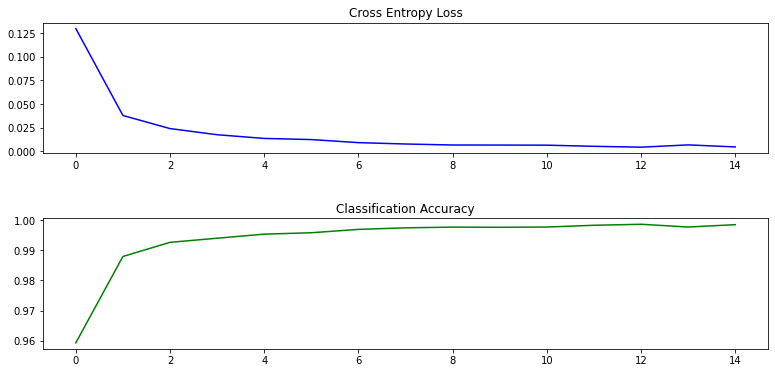

In [36]:
summarize_diagnostics(history,'03_model2')

# Save the model

In [37]:
#
# Save a model for later use
#
prefix = 'results/03_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

# set to True if the model should be saved
save_model = True
if save_model:
    model_json = model2.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model2.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))
    
else:

    # load model (has to be saved before, model is not part of git)    
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model2 = model_from_json(loaded_model_json)
    # load weights into new model
    model2.load_weights(weightName)
    print("loaded model from disk")
    

saved model to disk as results/03_model.json results/03_model.h5


# Task: Find characteristics in the errors of the model (1 point)

There are still too many false classifications using the model. Evaluate all test data and plot examples of failed classifications to get a better undestanding what goes wring. Plot a confusion matrix to get a better insight.

In [38]:
y_test_predictions = model2.predict(x_test)

In [39]:
#
# generate confusion matrix
# Task: find a suitable function for generating a confusion matrix as array
# 

confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_predictions,axis=1))


In [40]:
# make a nice plot of the confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


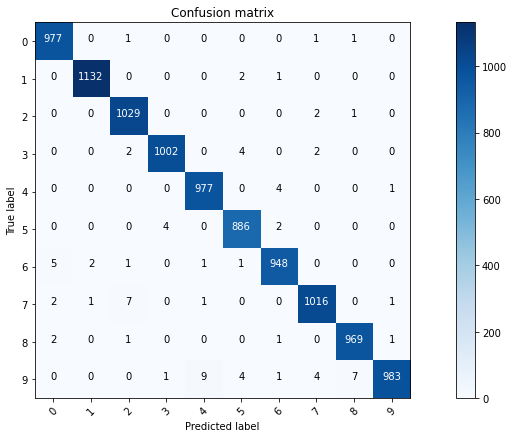

In [41]:
# plot confusion matrix
plot_confusion_matrix(confusion,['0','1','2','3','4','5','6','7','8','9'] )

# Task: Update your training strategy (2 points)

Beside many other options, there are two streight forward ways to improve your model:

1. Add more data for those classes which are poorely classified
1. Add augmentation for the training data

Implement the augmentation strategy and test if there is an improvement.


## Augmentation

Task: Search the internet for the ImageDataGenerator class of the Keras framework and implement such a generator for the training of the model. Select suitable augmentation which fits to the use-case. 
Document the resulting accuracy.

In [55]:
# Augmentation solution

# Since we are dealing with numbers, the only viable solution is a horizontal and vertical shift augmentation. Everything else would mess with the data, the numbers would not be numbers.
# Soures:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [56]:
generator = ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.08, 
                               shear_range=0.3, 
                               height_shift_range=0.08, 
                               zoom_range=0.08 )

it_train = generator.flow(x_train, y_train, batch_size=125)

In [57]:
# instantiate model
model3 = create_model_2()

In [59]:
steps = int(x_train.shape[0] / 128)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit_generator(it_train, steps_per_epoch=steps, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
468/468 [==============================] - 19s 41ms/step - loss: 0.2120 - accuracy: 0.9331 - val_loss: 0.0411 - val_accuracy: 0.9864
Epoch 2/15
468/468 [==============================] - 19s 41ms/step - loss: 0.0739 - accuracy: 0.9775 - val_loss: 0.0266 - val_accuracy: 0.9910
Epoch 3/15
468/468 [==============================] - 20s 42ms/step - loss: 0.0507 - accuracy: 0.9847 - val_loss: 0.0221 - val_accuracy: 0.9927
Epoch 4/15
468/468 [==============================] - 20s 43ms/step - loss: 0.0429 - accuracy: 0.9868 - val_loss: 0.0225 - val_accuracy: 0.9924
Epoch 5/15
468/468 [==============================] - 22s 47ms/step - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.0214 - val_accuracy: 0.9923
Epoch 6/15
468/468 [==============================] - 20s 42ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.0219 - val_accuracy: 0.9924
Epoch 7/15
468/468 [==============================] - 21s 46ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.0305 - val_accuracy:

In [60]:
#
# Evaluierung
#
_, acc = model3.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.995 


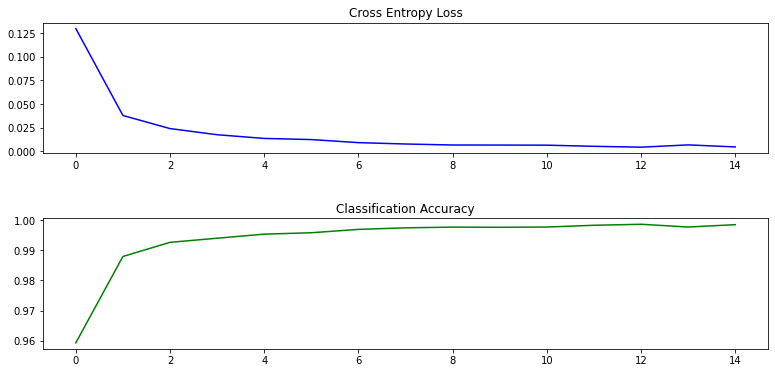

In [61]:
summarize_diagnostics(history,'03_model3')

In [62]:
y_test_predictions = model3.predict(x_test)

In [63]:
# generate confusion matrix
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_predictions,axis=1))

Confusion matrix, without normalization


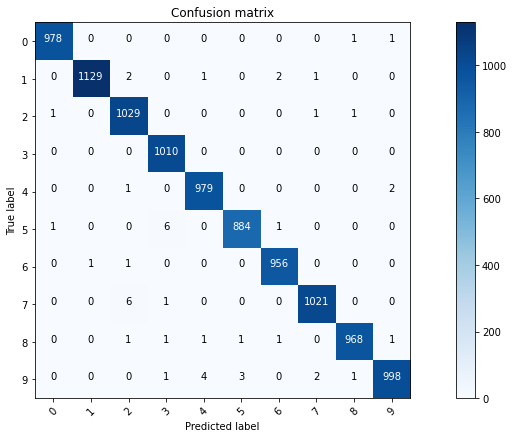

In [64]:
# plot confusion matrix
plot_confusion_matrix(confusion,['0','1','2','3','4','5','6','7','8','9'] )

In [ ]:
# After applying augmentation the model's accuracy increasde a tiny bit from .991 to .995
# We can also see in the confussion matrix that some of the errors have been reduced, e.g. eight and nine, or
# six and zero. But we have also introduced a few more mistakes, specifically with seven and three.